In [1]:
from tool import *


def gaussian_filter(img, kernel_size=5, sigma=1.4):
    kernel = np.fromfunction(
        lambda x, y: (1 / (2 * np.pi * (sigma**2)))
        * np.exp(
            -((x - (kernel_size - 1) / 2) ** 2 + (y - (kernel_size - 1) / 2) ** 2)
            / (2 * (sigma**2))
        ),
        (kernel_size, kernel_size),
    )
    kernel /= np.sum(kernel)
    filtered_img = cv2.filter2D(img, -1, kernel)
    return filtered_img


def sobel_filter(img):
    sobel_x_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y_kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    sobel_x = cv2.filter2D(img, -1, sobel_x_kernel)
    sobel_y = cv2.filter2D(img, -1, sobel_y_kernel)
    gradient_mag = np.hypot(sobel_x, sobel_y)
    # 将 gradient 的大小扩大到范围允许的最大值
    gradient_mag *= 255.0 / gradient_mag.max()
    # 可以处理 x 为 0 的情况
    gradient_angle = np.arctan2(sobel_y, sobel_x)
    return gradient_mag, gradient_angle


def non_maximum_suppression(gradient_mag, gradient_angle):
    # 先将 gradient_angle 的单位转成 deg 并合并相同情况
    gradient_angle_degree = gradient_angle * 180.0 / np.pi
    gradient_angle_degree[gradient_angle_degree < 0] += 180
    suppressed_img = np.zeros_like(gradient_mag)
    m, n = gradient_mag.shape
    for i in range(1, m - 1):
        for j in range(1, n - 1):
            # 一共有四种情况，注意坐标系不是笛卡尔坐标系，比较的对象在 gradient_angle 方向上
            if (0 <= gradient_angle_degree[i, j] < 22.5) or (
                157.5 <= gradient_angle_degree[i, j] <= 180
            ):
                a = gradient_mag[i, j + 1]
                b = gradient_mag[i, j - 1]
            elif 22.5 <= gradient_angle_degree[i, j] < 67.5:
                a = gradient_mag[i + 1, j - 1]
                b = gradient_mag[i - 1, j + 1]
            elif 67.5 <= gradient_angle_degree[i, j] < 112.5:
                a = gradient_mag[i + 1, j]
                b = gradient_mag[i - 1, j]
            elif 112.5 <= gradient_angle_degree[i, j] < 157.5:
                a = gradient_mag[i - 1, j - 1]
                b = gradient_mag[i + 1, j + 1]

            if (gradient_mag[i, j] > a) and (gradient_mag[i, j] > b):
                suppressed_img[i, j] = gradient_mag[i, j]
    return suppressed_img


def hysteresis_thresholding(img, low_threshold_ratio=0.05, high_threshold_ratio=0.09):
    threshold_high = img.max() * high_threshold_ratio
    threshold_low = img.max() * low_threshold_ratio

    thresholded = np.zeros_like(img)
    thresholded[np.where(img >= threshold_high)] = strong = 255
    thresholded[np.where((img < threshold_high) & (img >= threshold_low))] = weak = 50

    m, n = img.shape
    for i in range(1, m - 1):
        for j in range(1, n - 1):
            if img[i, j] == weak:
                if (
                    (img[i - 1, j - 1] == strong)
                    or (img[i - 1, j] == strong)
                    or (img[i - 1, j + 1] == strong)
                    or (img[i, j - 1] == strong)
                    or (img[i, j + 1] == strong)
                    or (img[i + 1, j - 1] == strong)
                    or (img[i + 1, j] == strong)
                    or (img[i + 1, j + 1] == strong)
                ):
                    img[i, j] = strong
                else:
                    img[i, j] = 0

    return thresholded


def canny_edge_detection(img, kernel_size=5, sigma=1.4, tl=0.05, th=0.09):
    print(
        f"Input Parameters:\nKernel Size: {kernel_size}, Sigma: {sigma}\ntl: {tl}, th: {th}"
    )
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gaussian_filtered = gaussian_filter(img_gray, kernel_size=5, sigma=1)
    # imshow(img_gaussian_filtered)
    img_suppressed = non_maximum_suppression(*sobel_filter(img_gaussian_filtered))
    # imshow(img_suppressed)
    img_thresholded = hysteresis_thresholding(
        img_suppressed, low_threshold_ratio=tl, high_threshold_ratio=th
    )
    # print('img_thresholded')
    # imshow(img_thresholded)
    return img_thresholded


kernel_1 = {"kernel_size": 3, "sigma": 0.5}
kernel_2 = {"kernel_size": 5, "sigma": 1.4}
kernel_3 = {"kernel_size": 7, "sigma": 3}
threshold_1 = {"tl": 0.08, "th": 0.15}
threshold_2 = {"tl": 0.12, "th": 0.20}
threshold_3 = {"tl": 0.20, "th": 0.30}

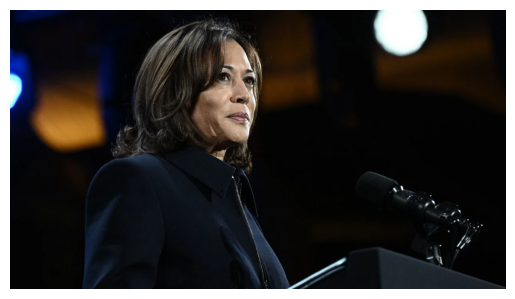

In [2]:
img = imread("3_canny_edge_detection.webp")

Input Parameters:
Kernel Size: 3, Sigma: 0.5
tl: 0.08, th: 0.15


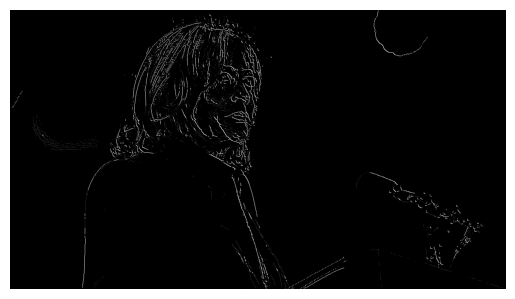

In [5]:
imshow(canny_edge_detection(img, **kernel_1, **threshold_1))

Input Parameters:
Kernel Size: 3, Sigma: 0.5
tl: 0.12, th: 0.2


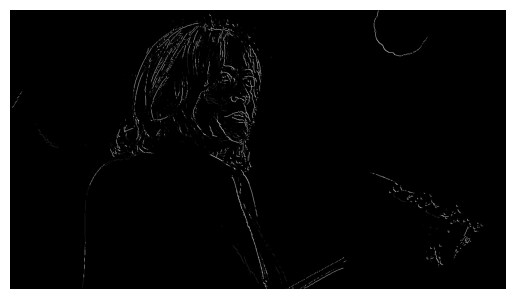

In [6]:
imshow(canny_edge_detection(img, **kernel_1, **threshold_2))

Input Parameters:
Kernel Size: 3, Sigma: 0.5
tl: 0.2, th: 0.3


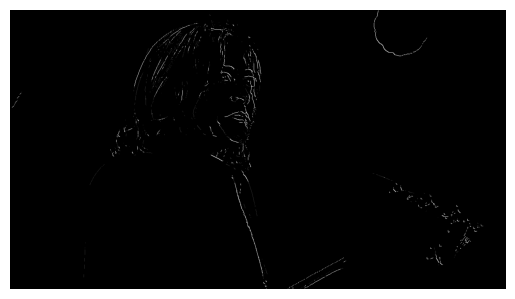

In [7]:
imshow(canny_edge_detection(img, **kernel_1, **threshold_3))

Input Parameters:
Kernel Size: 5, Sigma: 1.4
tl: 0.08, th: 0.15


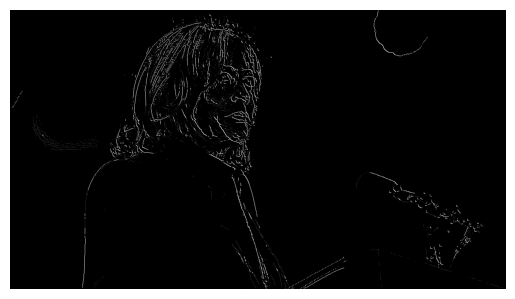

In [8]:
imshow(canny_edge_detection(img, **kernel_2, **threshold_1))

Input Parameters:
Kernel Size: 5, Sigma: 1.4
tl: 0.12, th: 0.2


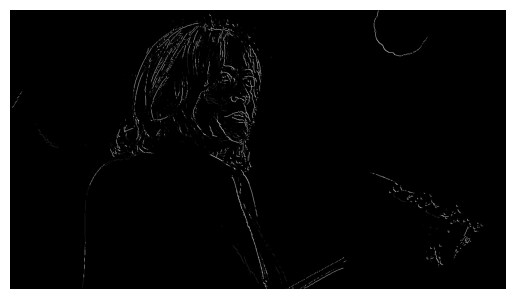

In [9]:
imshow(canny_edge_detection(img, **kernel_2, **threshold_2))

Input Parameters:
Kernel Size: 5, Sigma: 1.4
tl: 0.2, th: 0.3


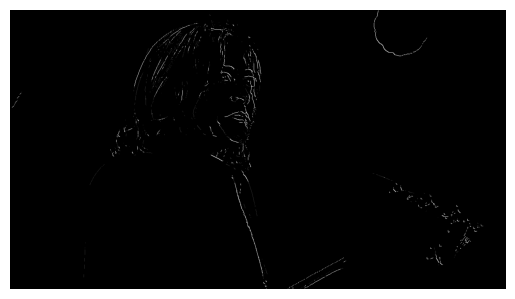

In [10]:
imshow(canny_edge_detection(img, **kernel_2, **threshold_3))

Input Parameters:
Kernel Size: 7, Sigma: 3
tl: 0.08, th: 0.15


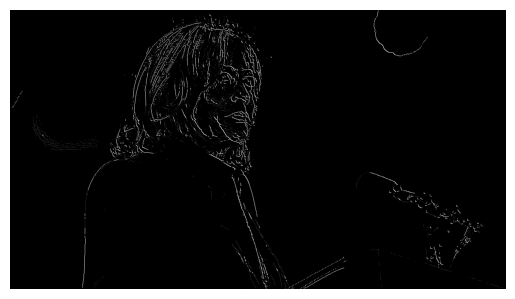

In [11]:
imshow(canny_edge_detection(img, **kernel_3, **threshold_1))

Input Parameters:
Kernel Size: 7, Sigma: 3
tl: 0.12, th: 0.2


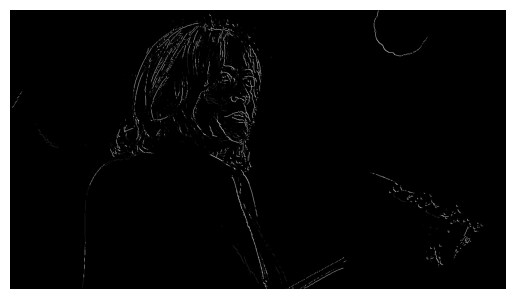

In [12]:
imshow(canny_edge_detection(img, **kernel_3, **threshold_2))

Input Parameters:
Kernel Size: 7, Sigma: 3
tl: 0.2, th: 0.3


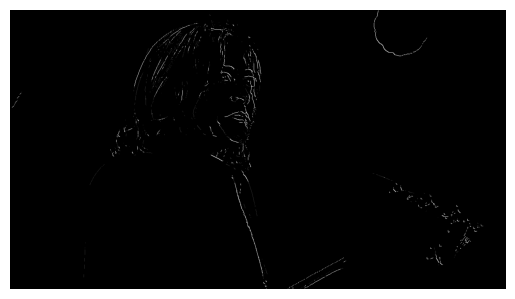

In [13]:
imshow(canny_edge_detection(img, **kernel_3, **threshold_3))